In [1]:
pip install tensorflow-addons

     |████████████████████████████████| 1.1 MB 7.6 MB/s 


In [2]:
# Setting the seed here is sufficient. 
# If you don't plan to use these starter code, make sure you add this cell.

SEED = 42

import os
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

import random 
random.seed(SEED)

import numpy as np
np.random.seed(SEED)

import tensorflow as tf
tf.random.set_seed(SEED)

import matplotlib.pyplot as plt

import math

import tensorflow_addons as tfa

from sklearn import preprocessing

In [3]:
from tensorflow import keras
from tensorflow.keras import layers
# from tensorflow.keras.layers import ...

from tensorflow.keras.layers import Normalization, StringLookup, IntegerLookup

In [4]:
import pandas as pd
df = pd.read_csv('hdb_price_prediction.csv')
df.head()

,month,year,full_address,nearest_stn,dist_to_nearest_stn,dist_to_dhoby,degree_centrality,eigenvector_centrality,flat_model_type,remaining_lease_years,floor_area_sqm,storey_range,resale_price
0,1,2017,406 ANG MO KIO AVENUE 10,Ang Mo Kio,1.007264,7.006044,0.016807,0.006243,"2 ROOM, Improved",61.333333,44.0,10 TO 12,232000.0
1,1,2017,108 ANG MO KIO AVENUE 4,Ang Mo Kio,1.271389,7.983837,0.016807,0.006243,"3 ROOM, New Generation",60.583333,67.0,01 TO 03,250000.0
2,1,2017,602 ANG MO KIO AVENUE 5,Yio Chu Kang,1.069743,9.090700,0.016807,0.002459,"3 ROOM, New Generation",62.416667,67.0,01 TO 03,262000.0
3,1,2017,465 ANG MO KIO AVENUE 10,Ang Mo Kio,0.946890,7.519889,0.016807,0.006243,"3 ROOM, New Generation",62.083333,68.0,04 TO 06,265000.0
4,1,2017,601 ANG MO KIO AVENUE 5,Yio Chu Kang,1.092551,9.130489,0.016807,0.002459,"3 ROOM, New Generation",62.416667,67.0,01 TO 03,265000.0


In [5]:
def dataframe_to_dataset(dataframe):
    dataframe = dataframe.copy()
    labels = dataframe.pop("resale_price")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds


def encode_numerical_feature(feature, name, dataset):
    # Create a Normalization layer for our feature
    normalizer = Normalization()

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the statistics of the data
    normalizer.adapt(feature_ds)

    # Normalize the input feature
    encoded_feature = normalizer(feature)
    return encoded_feature


def encode_categorical_feature(feature, name, dataset, is_string):
    lookup_class = StringLookup if is_string else IntegerLookup
    # Create a lookup layer which will turn strings into integer indices
    lookup = lookup_class(output_mode="binary") # NOTE: as mentioned in the question paper, this actually does one-hot encoding. You could replace 'binary' with 'one_hot' if you wish to.

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the set of possible string values and assign them a fixed integer index
    lookup.adapt(feature_ds)

    # Turn the string input into integer indices
    encoded_feature = lookup(feature)
    return encoded_feature


# 1a. Splitting dataset into train and test sets. Why is this done?

In [6]:
#Split data
train_dataframe = df[df['year'] <= 2020] # 0.8393471285568813
val_dataframe = df[df['year'] > 2020]

train_ds = dataframe_to_dataset(train_dataframe)
val_ds = dataframe_to_dataset(val_dataframe)

train_ds = train_ds.batch(128)
val_ds = val_ds.batch(128)



## This is such that the year would not be used as a factor of the resale price and to look in other possible factors instead.

# 1b. Design a 2-layer feedforward neural network

In [7]:
# Categorical features encoded as integers
month = keras.Input(shape=(1,), name="month", dtype="int64")
month_encoded = encode_categorical_feature(month, "month", train_ds, False)

# Categorical feature encoded as string
flat_model_type = keras.Input(shape=(1,), name="flat_model_type", dtype="string")
flat_model_type_encoded = encode_categorical_feature(flat_model_type, "flat_model_type", train_ds, True)
storey_range = keras.Input(shape=(1,), name="storey_range", dtype="string")
storey_range_encoded = encode_categorical_feature(storey_range, "storey_range", train_ds, True)

# Numerical features
floor_area_sqm = keras.Input(shape=(1,), name="floor_area_sqm")
floor_area_sqm_encoded = encode_numerical_feature(floor_area_sqm, "floor_area_sqm", train_ds)
dist_to_nearest_stn = keras.Input(shape=(1,), name="dist_to_nearest_stn")
dist_to_nearest_stn_encoded = encode_numerical_feature(dist_to_nearest_stn, "dist_to_nearest_stn", train_ds)
dist_to_dhoby = keras.Input(shape=(1,), name="dist_to_dhoby")
dist_to_dhoby_encoded = encode_numerical_feature(dist_to_dhoby, "dist_to_dhoby", train_ds)
degree_centrality = keras.Input(shape=(1,), name="degree_centrality")
degree_centrality_encoded = encode_numerical_feature(degree_centrality, "degree_centrality", train_ds)
eigenvector_centrality = keras.Input(shape=(1,), name="eigenvector_centrality")
eigenvector_centrality_encoded = encode_numerical_feature(eigenvector_centrality, "eigenvector_centrality", train_ds)
remaining_lease_years = keras.Input(shape=(1,), name="remaining_lease_years")
remaining_lease_years_encoded = encode_numerical_feature(remaining_lease_years, "remaining_lease_years", train_ds)

all_inputs = [
                month,
                flat_model_type,
                floor_area_sqm,
                storey_range,
                dist_to_nearest_stn,
                dist_to_dhoby,
                degree_centrality,
                eigenvector_centrality,
                remaining_lease_years,
              
             ]
all_features = layers.concatenate(
    [
        month_encoded,
        flat_model_type_encoded,
        floor_area_sqm_encoded,
        storey_range_encoded,
        dist_to_nearest_stn_encoded,
        dist_to_dhoby_encoded,
        degree_centrality_encoded,
        eigenvector_centrality_encoded,
        remaining_lease_years_encoded,
     
    ]
)


In [8]:
# feedforward network with one hidden layer
x = layers.Dense(10, activation="relu")(all_features)
output = layers.Dense(1, activation="linear")(x)
model = keras.Model(all_inputs, output)

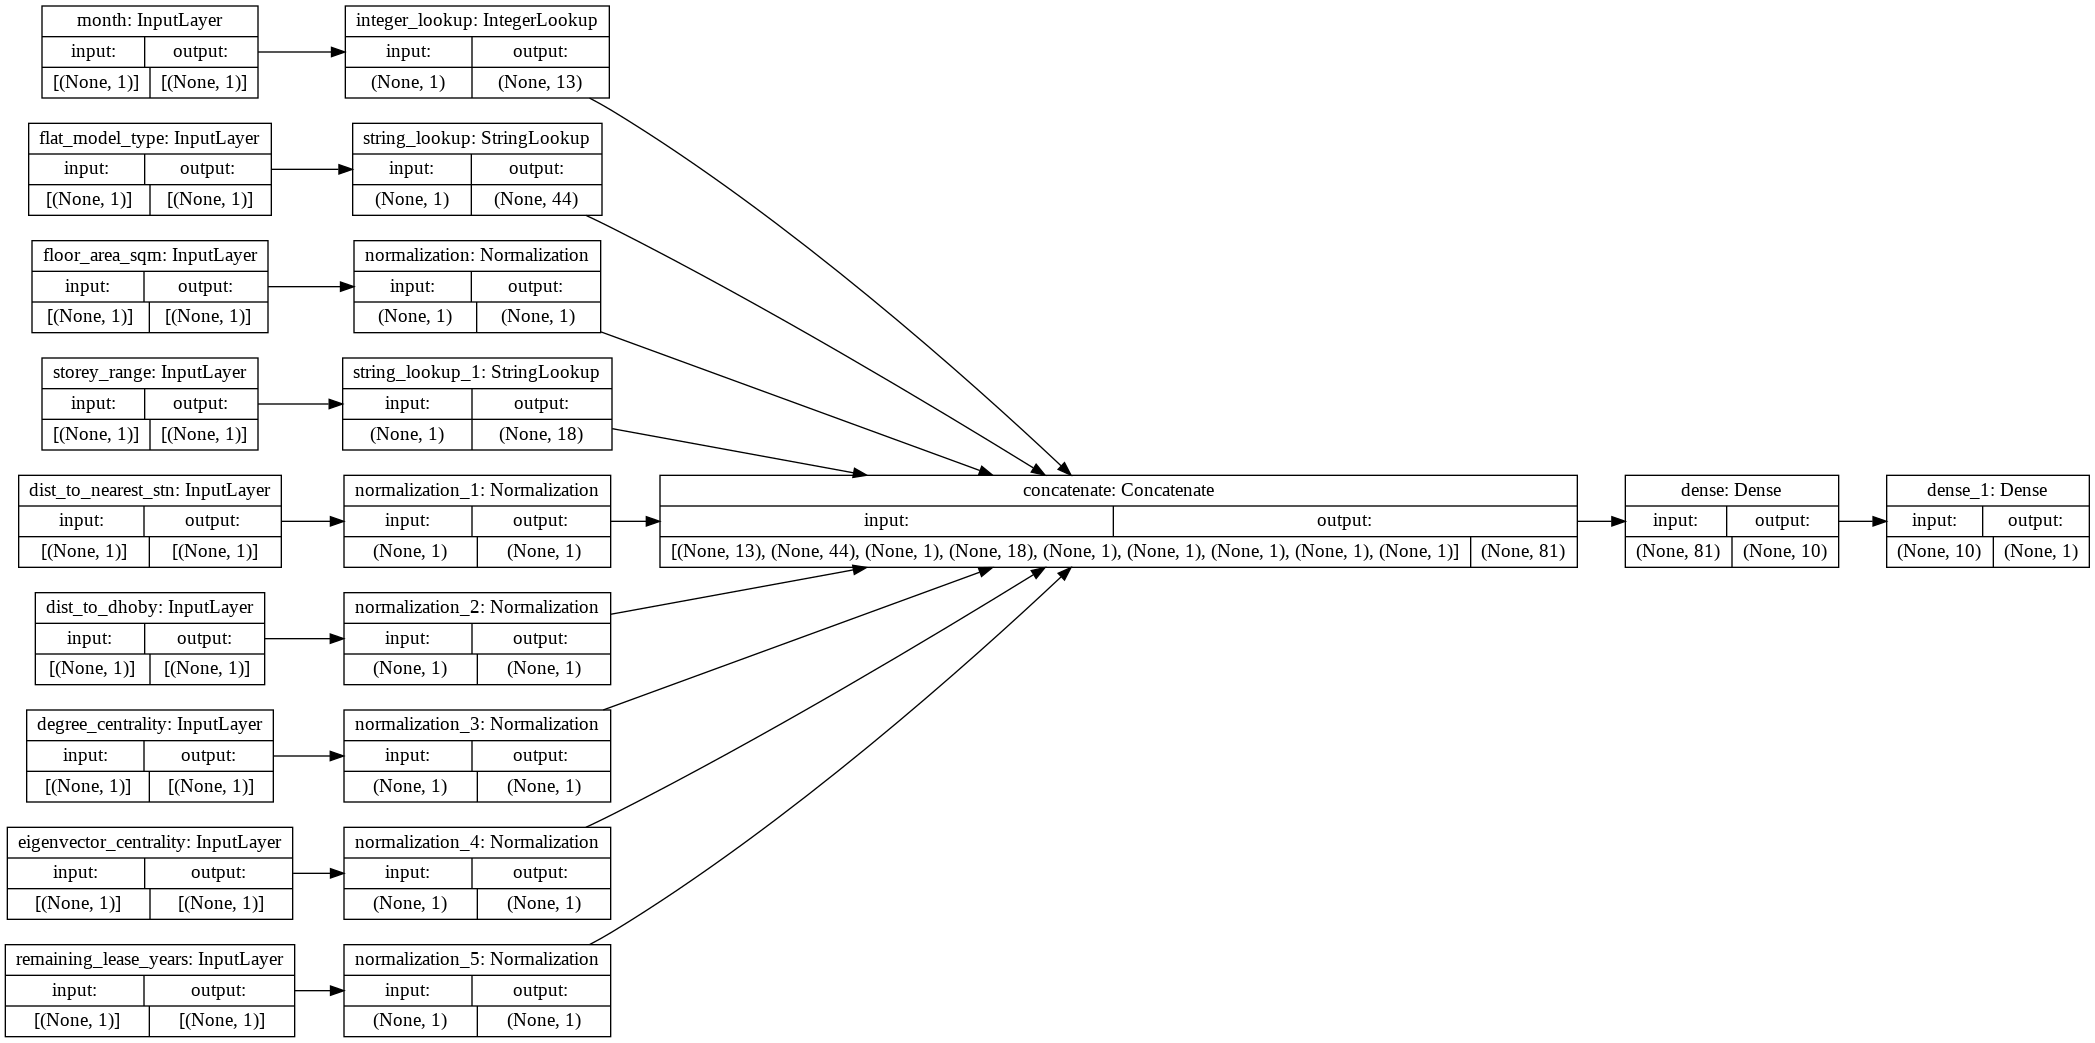

In [9]:
#architecture
keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

# 1c. Training the model

In [10]:
#Callback to restore best model weights for qns 1f.
checkpoint_filepath = './best_weights_file'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

In [11]:
#metric for r_square
r_square = tfa.metrics.RSquare(dtype=tf.float32, y_shape=(1,))

In [12]:

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.05), loss="mse", metrics=r_square)

model.fit(train_ds,
          batch_size=128,
          epochs=100, 
          verbose = 2, 
          use_multiprocessing=True,
          validation_data=val_ds,
          callbacks=[model_checkpoint_callback])

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['year', 'full_address', 'nearest_stn'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


683/683 - 4s - loss: 187121680384.0000 - r_square: -6.8675e+00 - val_loss: 170706681856.0000 - val_r_square: -5.5374e+00
INFO:tensorflow:Assets written to: ./best_weights_file/assets
Epoch 2/100
683/683 - 3s - loss: 67268124672.0000 - r_square: -1.8283e+00 - val_loss: 39908327424.0000 - val_r_square: -5.2832e-01
INFO:tensorflow:Assets written to: ./best_weights_file/assets
Epoch 3/100
683/683 - 3s - loss: 10862770176.0000 - r_square: 0.5433 - val_loss: 11038534656.0000 - val_r_square: 0.5773
INFO:tensorflow:Assets written to: ./best_weights_file/assets
Epoch 4/100
683/683 - 3s - loss: 5555056128.0000 - r_square: 0.7664 - val_loss: 8597992448.0000 - val_r_square: 0.6707
INFO:tensorflow:Assets written to: ./best_weights_file/assets
Epoch 5/100
683/683 - 3s - loss: 5012622848.0000 - r_square: 0.7892 - val_loss: 8004275712.0000 - val_r_square: 0.6935
INFO:tensorflow:Assets written to: ./best_weights_file/assets
Epoch 6/100
683/683 - 3s - loss: 4649051136.0000 - r_square: 0.8045 - val_loss:

# 1d. Plot the train and test root mean square errors (RMSE) against epochs

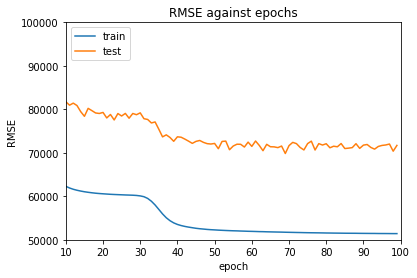

In [13]:
plt.figure(1)
train_graph = plt.plot(np.sqrt(model.history.history['loss']))
test_graph = plt.plot(np.sqrt(model.history.history['val_loss']))
plt.title('RMSE against epochs')
plt.ylabel('RMSE')
plt.xlabel('epoch')
plt.xlim([10,100])
plt.ylim([50000,100000])
#plt.xticks([20, 30, 40, 50, 60, 70, 80 ,90 ,100])
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# 1e. State the epoch with the lowest test error. State the test R2 value at that epoch.

In [14]:
#Find epoch number with lowest test error
list_test_error = np.sqrt(model.history.history['val_loss'])
list_r2_test_error = model.history.history['val_r_square']

min_test_error = min(list_test_error)
epoch_num = np.argmin(list_test_error)
r2_test_value = model.history.history['val_r_square'][epoch_num]


print('lowest test error =',min_test_error)
print('epoch number = %d'%(epoch_num+1))
print('R_square value = ',r2_test_value)





lowest test error = 69847.4974211675
epoch number = 70
R_square value =  0.8131668567657471


# 1f. Using the model from that best epoch, plot the predicted values and target values for a batch of 128 test samples.

In [15]:
model.load_weights(checkpoint_filepath)

def dataframe_to_dataset_no_shuffle(dataframe):
    dataframe = dataframe.copy()
    labels = dataframe.pop("resale_price")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    return ds

#prepare target values
predict_samples = val_dataframe.sample(n=128)
target_values = predict_samples['resale_price']

#prepare predicted_values
predict_samples = dataframe_to_dataset_no_shuffle(predict_samples).batch(128)
predicted_values = model.predict(predict_samples, batch_size=128,verbose=0,steps=1,use_multiprocessing=True)





/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['year', 'full_address', 'nearest_stn'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


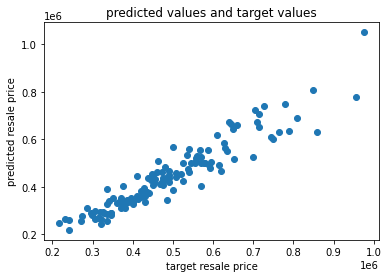

In [16]:
plt.figure(2)
plt.plot(target_values,predicted_values,marker='o',linestyle='None')

plt.title('predicted values and target values')
plt.ylabel('predicted resale price')
plt.xlabel('target resale price')
plt.show()

# 2a. Add an Embedding layer with output_dim = floor(num_categories/2)

In [ ]:
#embedded categorical features instead of one-hot encoding
def embed_categorical_feature(feature, name, dataset, is_string):
    lookup_class = StringLookup if is_string else IntegerLookup
    # Create a lookup layer which will turn strings into integer indices
    lookup = lookup_class(output_mode="int") 

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the set of possible string values and assign them a fixed integer index
    lookup.adapt(feature_ds)

    # Turn the string input into integer indices
    encoded_feature = lookup(feature)
    return encoded_feature

In [ ]:
#embed categorical inputs
month_embed = embed_categorical_feature(month, "month", train_ds, False)

flat_model_type_embed = embed_categorical_feature(flat_model_type, "flat_model_type", train_ds, True)

storey_range_embed = embed_categorical_feature(storey_range, "storey_range", train_ds, True)

print(flat_model_type_embed)

KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.int64, name=None), name='string_lookup_2/Identity:0', description="created by layer 'string_lookup_2'")


In [ ]:
# Categorical features embedded 
month_embedded = layers.Embedding(13, math.floor(13/2))(month_embed)
flat_model_type_embedded = layers.Embedding(44, math.floor(44/2))(flat_model_type_embed)
storey_range_embedded = layers.Embedding(18,math.floor(18/2))(storey_range_embed)


# 2b. Concatenate all features and train model

In [ ]:
# flatten 3d layes
month_embedded_flatten = layers.Flatten()(month_embedded)
flat_model_type_flatten = layers.Flatten()(flat_model_type_embedded)
storey_range_flatten = layers.Flatten()(storey_range_embedded)

all_features2 = layers.concatenate(
    [
        month_embedded_flatten,
        flat_model_type_flatten,
        floor_area_sqm_encoded,
        storey_range_flatten,
        dist_to_nearest_stn_encoded,
        dist_to_dhoby_encoded,
        degree_centrality_encoded,
        eigenvector_centrality_encoded,
        remaining_lease_years_encoded,
     
    ]
)


In [ ]:
#Defining model2

y = layers.Dense(10, activation="relu")(all_features2)
output2 = layers.Dense(1, activation="linear")(y)
model2 = keras.Model(all_inputs, output2)

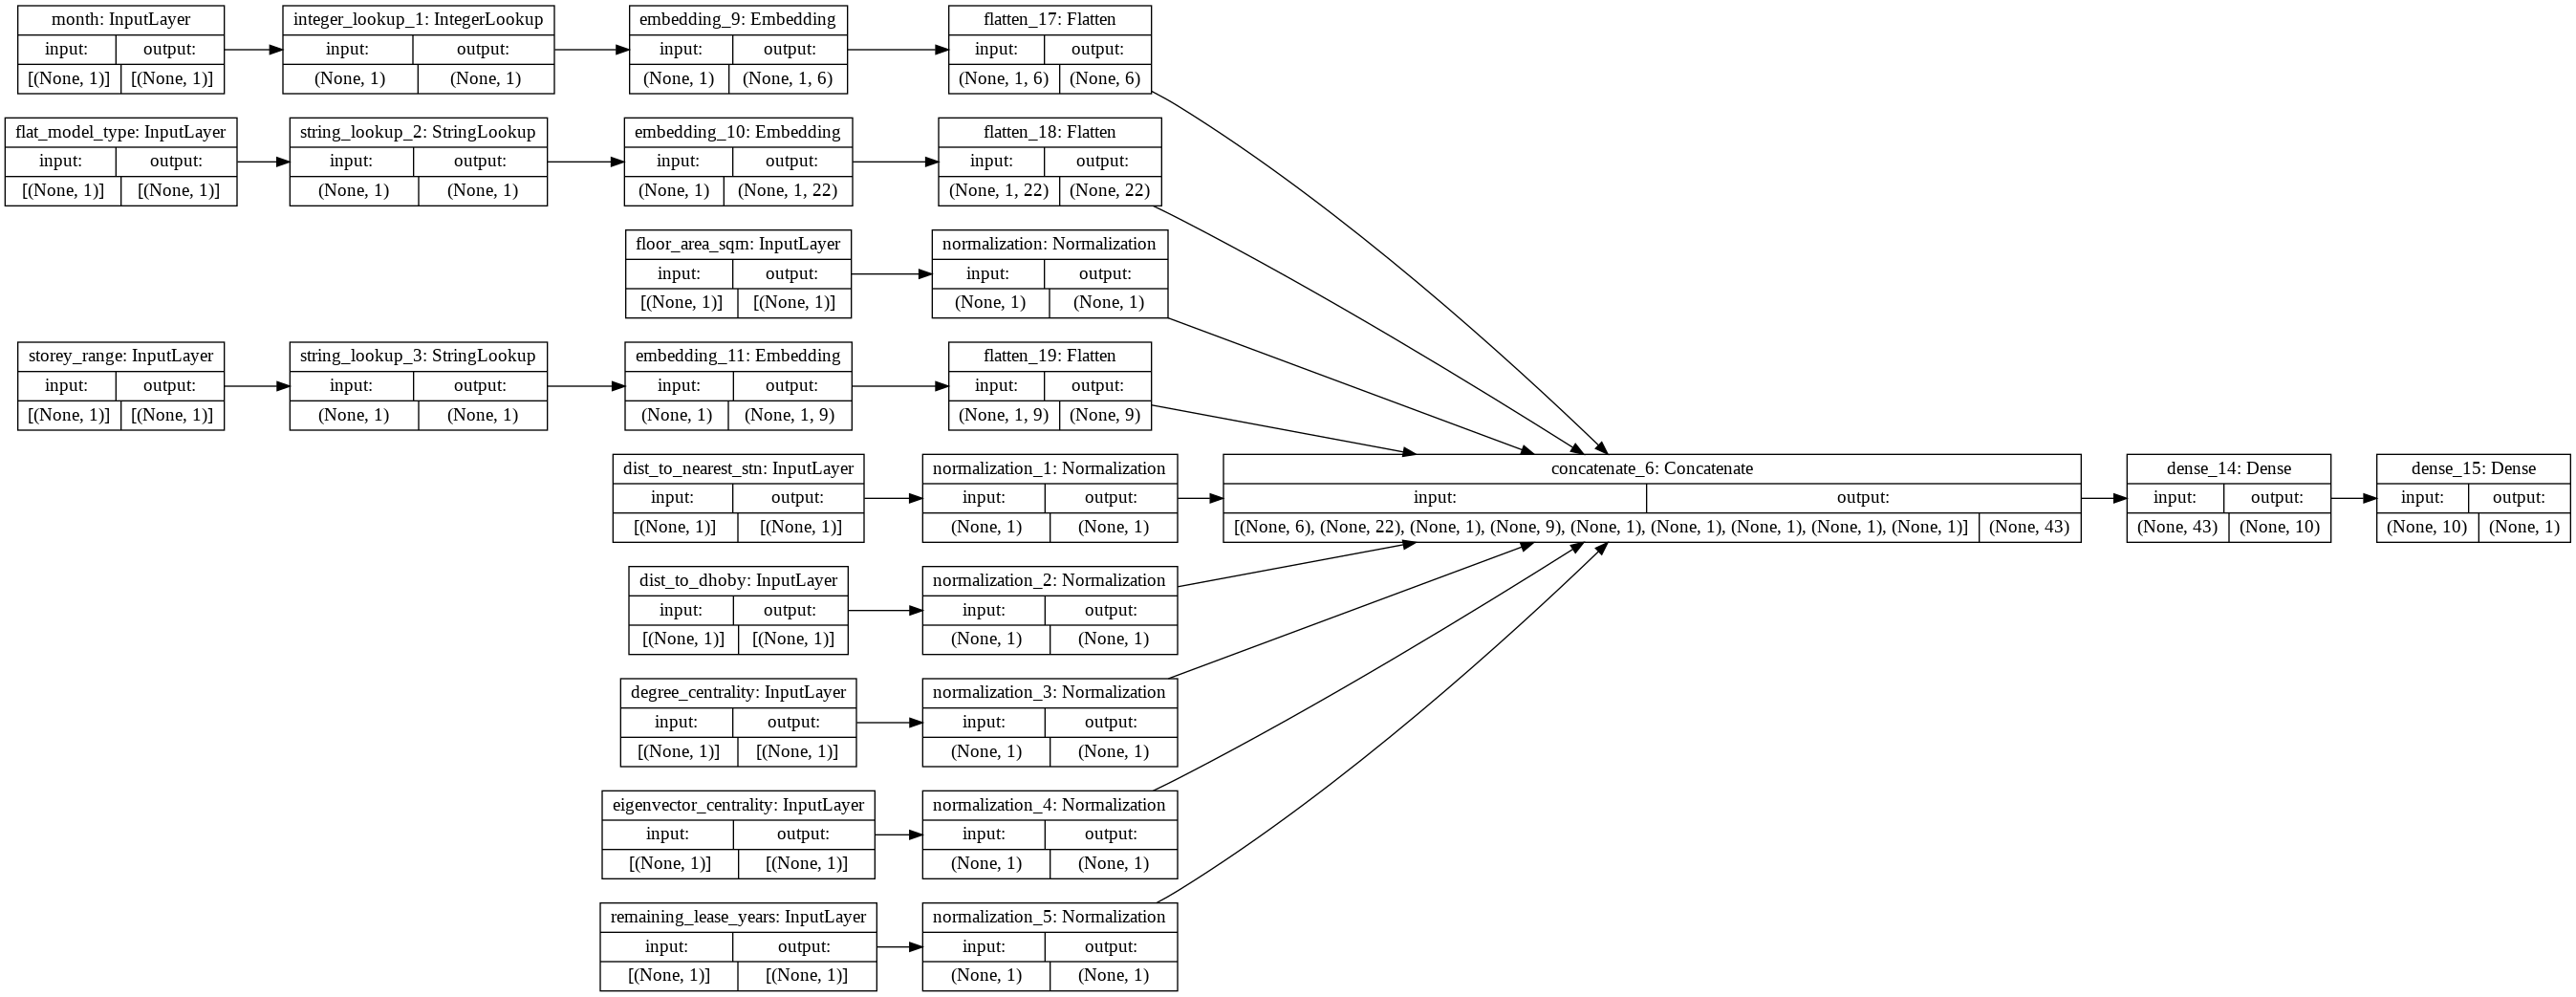

In [ ]:
# architecture of model 2
keras.utils.plot_model(model2, show_shapes=True, rankdir="LR")

In [ ]:
#Training model for qns 2

model2.compile(optimizer=keras.optimizers.Adam(learning_rate=0.05), loss="mse", metrics=r_square)

model2.fit(train_ds,
          batch_size=128,
          epochs=100, 
          verbose = 2, 
          use_multiprocessing=True,
          validation_data=val_ds)



Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['year', 'full_address', 'nearest_stn'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


683/683 - 4s - loss: 42357133312.0000 - r_square: -6.2296e-01 - val_loss: 11666167808.0000 - val_r_square: 0.5532
Epoch 2/100
683/683 - 2s - loss: 7625622016.0000 - r_square: 0.6794 - val_loss: 9361513472.0000 - val_r_square: 0.6415
Epoch 3/100
683/683 - 2s - loss: 6539409408.0000 - r_square: 0.7250 - val_loss: 8935446528.0000 - val_r_square: 0.6578
Epoch 4/100
683/683 - 3s - loss: 5721817088.0000 - r_square: 0.7594 - val_loss: 7582992384.0000 - val_r_square: 0.7096
Epoch 5/100
683/683 - 2s - loss: 5109594624.0000 - r_square: 0.7852 - val_loss: 7906586112.0000 - val_r_square: 0.6972
Epoch 6/100
683/683 - 3s - loss: 4685600768.0000 - r_square: 0.8030 - val_loss: 6794577408.0000 - val_r_square: 0.7398
Epoch 7/100
683/683 - 2s - loss: 4380416512.0000 - r_square: 0.8158 - val_loss: 6970800128.0000 - val_r_square: 0.7330
Epoch 8/100
683/683 - 3s - loss: 4158334720.0000 - r_square: 0.8252 - val_loss: 6056646656.0000 - val_r_square: 0.7681
Epoch 9/100
683/683 - 3s - loss: 4006657536.0000 - r_

# 2c.  Compare the current model performances in terms of both test RMSE and test R_square with the model from Q1 (at their own best epochs) and suggest a possible reason for the difference in performance. 

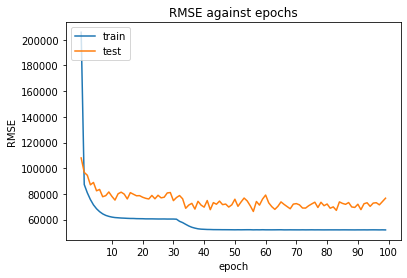

In [ ]:
# Plotting rmse against epochs for model2 
plt.figure(3)
train_graph = plt.plot(np.sqrt(model2.history.history['loss']))
test_graph = plt.plot(np.sqrt(model2.history.history['val_loss']))
plt.title('RMSE against epochs')
plt.ylabel('RMSE')
plt.xlabel('epoch')
plt.xticks([10, 20, 30, 40, 50, 60, 70, 80 ,90 ,100])
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
#Find epoch number with lowest test error
list2_test_error = np.sqrt(model2.history.history['val_loss'])
list2_r2_test_error = model2.history.history['val_r_square']

min2_test_error = min(list2_test_error)
epoch2_num = np.argmin(list2_test_error)
r2_test_value2 = model2.history.history['val_r_square'][epoch2_num]

#Print values for model 2
print('lowest test error =',min2_test_error)
print('epoch number = %d'%(epoch2_num+1))
print('R_square value = ',r2_test_value2)

lowest test error = 66350.97177886697
epoch number = 57
R_square value =  0.8314036130905151


## The model from question 2 has a lower test error and a higher R2 value, which is better. Embedding helps to encode more meaningful relationships among the categorise, which allows better accuracy in predicting as compared to just cramming all information of a category into a number.

# 3a. Callback for early stopping

In [ ]:
#Defining early stopping
def early_stop_callback(name):
  return [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)]

# 3b. Features elimination

In [ ]:
#defining function for RFE
def RFE(features, all_inputs):
  test_RMSE = []
  test_all_inputs = all_inputs[:]
  test_features = features[:]
  for i in range(len(features)):
    test_features.pop(i)
    test_all_inputs.pop(i)
    test_inputs = layers.concatenate(test_features)
    z = layers.Dense(10, activation="relu")(test_inputs)
    output3 = layers.Dense(1, activation="linear")(z)
    test_model = keras.Model(test_all_inputs, output3)
    test_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.05), loss="mse", metrics=r_square)
    test_model.fit(train_ds,
                batch_size=128,
                epochs=100, 
                verbose = 2, 
                use_multiprocessing=True,
                validation_data=val_ds,
                callbacks=[early_stop_callback("name")])
    test_RMSE.append(np.sqrt(min(test_model.history.history['val_loss'])))
    test_features = features[:]
    test_all_inputs = all_inputs[:]
  return test_RMSE

    


In [ ]:
test_features = [
                    month_embedded_flatten,
                    flat_model_type_flatten,
                    floor_area_sqm_encoded,
                    storey_range_flatten,
                    dist_to_nearest_stn_encoded,
                    dist_to_dhoby_encoded,
                    degree_centrality_encoded,
                    eigenvector_centrality_encoded,
                    remaining_lease_years_encoded,
                
                ]
                
               
test_RMSE = RFE(features = test_features, all_inputs = all_inputs)

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['month', 'year', 'full_address', 'nearest_stn'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


683/683 - 3s - loss: 43428794368.0000 - r_square: -5.1902e-01 - val_loss: 10855135232.0000 - val_r_square: 0.5843
Epoch 2/100
683/683 - 2s - loss: 8054426112.0000 - r_square: 0.6614 - val_loss: 9981288448.0000 - val_r_square: 0.6178
Epoch 3/100
683/683 - 3s - loss: 7331388416.0000 - r_square: 0.6918 - val_loss: 9410432000.0000 - val_r_square: 0.6396
Epoch 4/100
683/683 - 2s - loss: 6691395072.0000 - r_square: 0.7187 - val_loss: 8330849792.0000 - val_r_square: 0.6810
Epoch 5/100
683/683 - 2s - loss: 6045306368.0000 - r_square: 0.7458 - val_loss: 7900946944.0000 - val_r_square: 0.6974
Epoch 6/100
683/683 - 2s - loss: 5464064000.0000 - r_square: 0.7703 - val_loss: 7283012096.0000 - val_r_square: 0.7211
Epoch 7/100
683/683 - 2s - loss: 5029178368.0000 - r_square: 0.7885 - val_loss: 7023931904.0000 - val_r_square: 0.7310
Epoch 8/100
683/683 - 3s - loss: 4710245888.0000 - r_square: 0.8020 - val_loss: 6890633216.0000 - val_r_square: 0.7361
Epoch 9/100
683/683 - 2s - loss: 4470065664.0000 - r_

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['year', 'full_address', 'nearest_stn', 'flat_model_type'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


683/683 - 19s - loss: 57138671616.0000 - r_square: -9.8790e-01 - val_loss: 25217052672.0000 - val_r_square: 0.0343
Epoch 2/100
683/683 - 3s - loss: 18814875648.0000 - r_square: 0.2089 - val_loss: 23664205824.0000 - val_r_square: 0.0938
Epoch 3/100
683/683 - 3s - loss: 17520087040.0000 - r_square: 0.2634 - val_loss: 22196660224.0000 - val_r_square: 0.1500
Epoch 4/100
683/683 - 2s - loss: 16102792192.0000 - r_square: 0.3229 - val_loss: 19848972288.0000 - val_r_square: 0.2399
Epoch 5/100
683/683 - 3s - loss: 14199839744.0000 - r_square: 0.4030 - val_loss: 18455537664.0000 - val_r_square: 0.2932
Epoch 6/100
683/683 - 3s - loss: 11784513536.0000 - r_square: 0.5045 - val_loss: 15126000640.0000 - val_r_square: 0.4207
Epoch 7/100
683/683 - 2s - loss: 9215063040.0000 - r_square: 0.6125 - val_loss: 11747362816.0000 - val_r_square: 0.5501
Epoch 8/100
683/683 - 2s - loss: 7028890624.0000 - r_square: 0.7045 - val_loss: 9558828032.0000 - val_r_square: 0.6339
Epoch 9/100
683/683 - 3s - loss: 55628846

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['year', 'full_address', 'nearest_stn', 'floor_area_sqm'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


683/683 - 3s - loss: 34078545920.0000 - r_square: -2.0519e-01 - val_loss: 10831337472.0000 - val_r_square: 0.5852
Epoch 2/100
683/683 - 2s - loss: 8120657920.0000 - r_square: 0.6586 - val_loss: 10269276160.0000 - val_r_square: 0.6067
Epoch 3/100
683/683 - 2s - loss: 7490841088.0000 - r_square: 0.6850 - val_loss: 9810341888.0000 - val_r_square: 0.6243
Epoch 4/100
683/683 - 2s - loss: 6875361280.0000 - r_square: 0.7109 - val_loss: 9007426560.0000 - val_r_square: 0.6551
Epoch 5/100
683/683 - 3s - loss: 6177797632.0000 - r_square: 0.7403 - val_loss: 7570421760.0000 - val_r_square: 0.7101
Epoch 6/100
683/683 - 3s - loss: 5539639296.0000 - r_square: 0.7671 - val_loss: 7022397952.0000 - val_r_square: 0.7311
Epoch 7/100
683/683 - 2s - loss: 5091692544.0000 - r_square: 0.7859 - val_loss: 7583351296.0000 - val_r_square: 0.7096
Epoch 8/100
683/683 - 3s - loss: 4793321472.0000 - r_square: 0.7985 - val_loss: 7302311424.0000 - val_r_square: 0.7204
Epoch 9/100
683/683 - 2s - loss: 4582463488.0000 - r

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['year', 'full_address', 'nearest_stn', 'storey_range'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


683/683 - 4s - loss: 37242875904.0000 - r_square: -3.0887e-01 - val_loss: 13505233920.0000 - val_r_square: 0.4828
Epoch 2/100
683/683 - 2s - loss: 9808584704.0000 - r_square: 0.5876 - val_loss: 12544162816.0000 - val_r_square: 0.5196
Epoch 3/100
683/683 - 3s - loss: 9075201024.0000 - r_square: 0.6184 - val_loss: 11911508992.0000 - val_r_square: 0.5438
Epoch 4/100
683/683 - 2s - loss: 8241912832.0000 - r_square: 0.6535 - val_loss: 10213446656.0000 - val_r_square: 0.6089
Epoch 5/100
683/683 - 3s - loss: 7285965312.0000 - r_square: 0.6937 - val_loss: 10772284416.0000 - val_r_square: 0.5875
Epoch 6/100
683/683 - 2s - loss: 6437272064.0000 - r_square: 0.7293 - val_loss: 8216874496.0000 - val_r_square: 0.6853
Epoch 7/100
683/683 - 2s - loss: 5862509568.0000 - r_square: 0.7535 - val_loss: 8421348864.0000 - val_r_square: 0.6775
Epoch 8/100
683/683 - 2s - loss: 5404734464.0000 - r_square: 0.7728 - val_loss: 7593577984.0000 - val_r_square: 0.7092
Epoch 9/100
683/683 - 2s - loss: 4966600192.0000 

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['year', 'full_address', 'nearest_stn', 'dist_to_nearest_stn'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


683/683 - 3s - loss: 30556047360.0000 - r_square: -8.5662e-02 - val_loss: 10666904576.0000 - val_r_square: 0.5915
Epoch 2/100
683/683 - 3s - loss: 8353655808.0000 - r_square: 0.6488 - val_loss: 10537568256.0000 - val_r_square: 0.5965
Epoch 3/100
683/683 - 2s - loss: 7895114240.0000 - r_square: 0.6680 - val_loss: 10194362368.0000 - val_r_square: 0.6096
Epoch 4/100
683/683 - 3s - loss: 7458870784.0000 - r_square: 0.6864 - val_loss: 9931600896.0000 - val_r_square: 0.6197
Epoch 5/100
683/683 - 2s - loss: 6933110272.0000 - r_square: 0.7085 - val_loss: 9262059520.0000 - val_r_square: 0.6453
Epoch 6/100
683/683 - 2s - loss: 6368467456.0000 - r_square: 0.7322 - val_loss: 8562116608.0000 - val_r_square: 0.6721
Epoch 7/100
683/683 - 3s - loss: 5866787328.0000 - r_square: 0.7533 - val_loss: 7781234688.0000 - val_r_square: 0.7020
Epoch 8/100
683/683 - 3s - loss: 5495368704.0000 - r_square: 0.7689 - val_loss: 7838028800.0000 - val_r_square: 0.6998
Epoch 9/100
683/683 - 2s - loss: 5218080768.0000 - 

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['year', 'full_address', 'nearest_stn', 'dist_to_dhoby'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


683/683 - 3s - loss: 36672811008.0000 - r_square: -2.9228e-01 - val_loss: 11267867648.0000 - val_r_square: 0.5685
Epoch 2/100
683/683 - 3s - loss: 8594766848.0000 - r_square: 0.6386 - val_loss: 10967453696.0000 - val_r_square: 0.5800
Epoch 3/100
683/683 - 2s - loss: 8356425216.0000 - r_square: 0.6486 - val_loss: 10784610304.0000 - val_r_square: 0.5870
Epoch 4/100
683/683 - 2s - loss: 8173230080.0000 - r_square: 0.6564 - val_loss: 10343283712.0000 - val_r_square: 0.6039
Epoch 5/100
683/683 - 3s - loss: 7970474496.0000 - r_square: 0.6649 - val_loss: 10186316800.0000 - val_r_square: 0.6099
Epoch 6/100
683/683 - 2s - loss: 7742356992.0000 - r_square: 0.6745 - val_loss: 10344471552.0000 - val_r_square: 0.6039
Epoch 7/100
683/683 - 3s - loss: 7484815360.0000 - r_square: 0.6853 - val_loss: 9730181120.0000 - val_r_square: 0.6274
Epoch 8/100
683/683 - 3s - loss: 7215726592.0000 - r_square: 0.6966 - val_loss: 9953831936.0000 - val_r_square: 0.6188
Epoch 9/100
683/683 - 3s - loss: 6989314048.0000

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['year', 'full_address', 'nearest_stn', 'degree_centrality'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


683/683 - 3s - loss: 39915024384.0000 - r_square: -4.2056e-01 - val_loss: 10642045952.0000 - val_r_square: 0.5925
Epoch 2/100
683/683 - 3s - loss: 8135684096.0000 - r_square: 0.6579 - val_loss: 10182881280.0000 - val_r_square: 0.6100
Epoch 3/100
683/683 - 3s - loss: 7290714112.0000 - r_square: 0.6935 - val_loss: 9081771008.0000 - val_r_square: 0.6522
Epoch 4/100
683/683 - 2s - loss: 6375647232.0000 - r_square: 0.7319 - val_loss: 7922920448.0000 - val_r_square: 0.6966
Epoch 5/100
683/683 - 2s - loss: 5571267584.0000 - r_square: 0.7658 - val_loss: 7057977856.0000 - val_r_square: 0.7297
Epoch 6/100
683/683 - 3s - loss: 4990680064.0000 - r_square: 0.7902 - val_loss: 7550060544.0000 - val_r_square: 0.7109
Epoch 7/100
683/683 - 3s - loss: 4645283328.0000 - r_square: 0.8047 - val_loss: 8199578624.0000 - val_r_square: 0.6860
Epoch 8/100
683/683 - 3s - loss: 4344650240.0000 - r_square: 0.8173 - val_loss: 6222534656.0000 - val_r_square: 0.7617
Epoch 9/100
683/683 - 3s - loss: 3946026240.0000 - r

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['year', 'full_address', 'nearest_stn', 'eigenvector_centrality'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


683/683 - 4s - loss: 27972415488.0000 - r_square: 0.0121 - val_loss: 10940156928.0000 - val_r_square: 0.5810
Epoch 2/100
683/683 - 3s - loss: 8441633280.0000 - r_square: 0.6451 - val_loss: 10724210688.0000 - val_r_square: 0.5893
Epoch 3/100
683/683 - 2s - loss: 8003967488.0000 - r_square: 0.6635 - val_loss: 10001647616.0000 - val_r_square: 0.6170
Epoch 4/100
683/683 - 2s - loss: 7568685568.0000 - r_square: 0.6818 - val_loss: 10054957056.0000 - val_r_square: 0.6149
Epoch 5/100
683/683 - 3s - loss: 6991524352.0000 - r_square: 0.7060 - val_loss: 8622767104.0000 - val_r_square: 0.6698
Epoch 6/100
683/683 - 3s - loss: 6248466432.0000 - r_square: 0.7373 - val_loss: 8048417792.0000 - val_r_square: 0.6918
Epoch 7/100
683/683 - 2s - loss: 5496597504.0000 - r_square: 0.7689 - val_loss: 6649116160.0000 - val_r_square: 0.7454
Epoch 8/100
683/683 - 2s - loss: 4906210304.0000 - r_square: 0.7937 - val_loss: 7893005312.0000 - val_r_square: 0.6977
Epoch 9/100
683/683 - 3s - loss: 4498862592.0000 - r_sq

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['year', 'full_address', 'nearest_stn', 'remaining_lease_years'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


683/683 - 4s - loss: 33850421248.0000 - r_square: -1.9074e-01 - val_loss: 11191565312.0000 - val_r_square: 0.5714
Epoch 2/100
683/683 - 3s - loss: 8532371456.0000 - r_square: 0.6413 - val_loss: 11164703744.0000 - val_r_square: 0.5724
Epoch 3/100
683/683 - 3s - loss: 8162815488.0000 - r_square: 0.6568 - val_loss: 10366288896.0000 - val_r_square: 0.6030
Epoch 4/100
683/683 - 2s - loss: 7853995520.0000 - r_square: 0.6698 - val_loss: 10293733376.0000 - val_r_square: 0.6058
Epoch 5/100
683/683 - 3s - loss: 7485157376.0000 - r_square: 0.6853 - val_loss: 9067593728.0000 - val_r_square: 0.6527
Epoch 6/100
683/683 - 3s - loss: 7023766528.0000 - r_square: 0.7047 - val_loss: 8936294400.0000 - val_r_square: 0.6578
Epoch 7/100
683/683 - 2s - loss: 6493675520.0000 - r_square: 0.7270 - val_loss: 8659873792.0000 - val_r_square: 0.6684
Epoch 8/100
683/683 - 3s - loss: 5976472064.0000 - r_square: 0.7487 - val_loss: 8356632576.0000 - val_r_square: 0.6800
Epoch 9/100
683/683 - 2s - loss: 5582464512.0000 -

In [ ]:
#Plotting table of removed feature and the RMSE
df1 = pd.DataFrame(np.array([test_RMSE]),
                   columns=[  "month",
                              "flat_model_type",
                              "floor_area_sqm",
                              "storey_range",
                              "dist_to_nearest_stn",
                              "dist_to_dhoby",
                              "degree_centrality",
                              "eigenvector_centrality",
                              "remaining_lease_years"],
                   index=['RMSE'])
                
df1


,month,flat_model_type,floor_area_sqm,storey_range,dist_to_nearest_stn,dist_to_dhoby,degree_centrality,eigenvector_centrality,remaining_lease_years
RMSE,72136.017301,80252.621938,73829.208312,73255.007092,75722.572381,88468.666182,69148.660725,66281.637155,73539.011253


## From the table, removing the eigenvector_centrality  results in lower RMSE value, thus is chosen for elimination

In [ ]:
#Removing eigenvector_centrality
test_features2 = [
                    month_embedded_flatten,
                    flat_model_type_flatten,
                    floor_area_sqm_encoded,
                    storey_range_flatten,
                    dist_to_nearest_stn_encoded,
                    dist_to_dhoby_encoded,
                    degree_centrality_encoded,
                    remaining_lease_years_encoded,               
                 ]

all_inputs2 = [
                month,
                flat_model_type,
                floor_area_sqm,
                storey_range,
                dist_to_nearest_stn,
                dist_to_dhoby,
                degree_centrality,
                remaining_lease_years,             
              ]
test_RMSE2 = RFE(features = test_features2, all_inputs = all_inputs2)

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['month', 'year', 'full_address', 'nearest_stn', 'eigenvector_centrality'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


683/683 - 3s - loss: 25999441920.0000 - r_square: 0.0681 - val_loss: 10912096256.0000 - val_r_square: 0.5821
Epoch 2/100
683/683 - 3s - loss: 8251425280.0000 - r_square: 0.6531 - val_loss: 10808200192.0000 - val_r_square: 0.5861
Epoch 3/100
683/683 - 2s - loss: 7788215296.0000 - r_square: 0.6725 - val_loss: 9378045952.0000 - val_r_square: 0.6409
Epoch 4/100
683/683 - 2s - loss: 7197374464.0000 - r_square: 0.6974 - val_loss: 9985452032.0000 - val_r_square: 0.6176
Epoch 5/100
683/683 - 2s - loss: 6413635584.0000 - r_square: 0.7303 - val_loss: 7625477120.0000 - val_r_square: 0.7080
Epoch 6/100
683/683 - 3s - loss: 5589674496.0000 - r_square: 0.7650 - val_loss: 7141105152.0000 - val_r_square: 0.7265
Epoch 7/100
683/683 - 2s - loss: 4918627840.0000 - r_square: 0.7932 - val_loss: 6896999936.0000 - val_r_square: 0.7359
Epoch 8/100
683/683 - 2s - loss: 4454596096.0000 - r_square: 0.8127 - val_loss: 6175501824.0000 - val_r_square: 0.7635
Epoch 9/100
683/683 - 3s - loss: 4148915200.0000 - r_squa

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['year', 'full_address', 'nearest_stn', 'eigenvector_centrality', 'flat_model_type'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


683/683 - 3s - loss: 67045654528.0000 - r_square: -1.3173e+00 - val_loss: 25616506880.0000 - val_r_square: 0.0190
Epoch 2/100
683/683 - 2s - loss: 19958116352.0000 - r_square: 0.1609 - val_loss: 25102286848.0000 - val_r_square: 0.0387
Epoch 3/100
683/683 - 3s - loss: 19406508032.0000 - r_square: 0.1841 - val_loss: 23869794304.0000 - val_r_square: 0.0859
Epoch 4/100
683/683 - 2s - loss: 18990530560.0000 - r_square: 0.2015 - val_loss: 24145336320.0000 - val_r_square: 0.0753
Epoch 5/100
683/683 - 2s - loss: 18579056640.0000 - r_square: 0.2188 - val_loss: 23011184640.0000 - val_r_square: 0.1188
Epoch 6/100
683/683 - 2s - loss: 18105063424.0000 - r_square: 0.2388 - val_loss: 23043405824.0000 - val_r_square: 0.1175
Epoch 7/100
683/683 - 2s - loss: 17501349888.0000 - r_square: 0.2642 - val_loss: 22304292864.0000 - val_r_square: 0.1458
Epoch 8/100
683/683 - 2s - loss: 16704361472.0000 - r_square: 0.2977 - val_loss: 21613015040.0000 - val_r_square: 0.1723
Epoch 9/100
683/683 - 2s - loss: 156636

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['year', 'full_address', 'nearest_stn', 'eigenvector_centrality', 'floor_area_sqm'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


683/683 - 3s - loss: 32906614784.0000 - r_square: -1.6896e-01 - val_loss: 11532687360.0000 - val_r_square: 0.5583
Epoch 2/100
683/683 - 3s - loss: 8674407424.0000 - r_square: 0.6353 - val_loss: 10325634048.0000 - val_r_square: 0.6046
Epoch 3/100
683/683 - 3s - loss: 8307145728.0000 - r_square: 0.6507 - val_loss: 10502752256.0000 - val_r_square: 0.5978
Epoch 4/100
683/683 - 3s - loss: 8023651840.0000 - r_square: 0.6626 - val_loss: 9914238976.0000 - val_r_square: 0.6203
Epoch 5/100
683/683 - 2s - loss: 7713460224.0000 - r_square: 0.6757 - val_loss: 9768671232.0000 - val_r_square: 0.6259
Epoch 6/100
683/683 - 2s - loss: 7316589568.0000 - r_square: 0.6924 - val_loss: 9003714560.0000 - val_r_square: 0.6552
Epoch 7/100
683/683 - 3s - loss: 6798437888.0000 - r_square: 0.7142 - val_loss: 8918909952.0000 - val_r_square: 0.6584
Epoch 8/100
683/683 - 3s - loss: 6208665088.0000 - r_square: 0.7390 - val_loss: 8182974976.0000 - val_r_square: 0.6866
Epoch 9/100
683/683 - 2s - loss: 5627492864.0000 - 

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['year', 'full_address', 'nearest_stn', 'eigenvector_centrality', 'storey_range'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


683/683 - 3s - loss: 36437135360.0000 - r_square: -2.7705e-01 - val_loss: 13711603712.0000 - val_r_square: 0.4749
Epoch 2/100
683/683 - 2s - loss: 10548259840.0000 - r_square: 0.5565 - val_loss: 13530030080.0000 - val_r_square: 0.4819
Epoch 3/100
683/683 - 2s - loss: 10165477376.0000 - r_square: 0.5726 - val_loss: 12688157696.0000 - val_r_square: 0.5141
Epoch 4/100
683/683 - 3s - loss: 9798398976.0000 - r_square: 0.5880 - val_loss: 12025235456.0000 - val_r_square: 0.5395
Epoch 5/100
683/683 - 3s - loss: 9386651648.0000 - r_square: 0.6053 - val_loss: 12058182656.0000 - val_r_square: 0.5382
Epoch 6/100
683/683 - 2s - loss: 8846971904.0000 - r_square: 0.6280 - val_loss: 11145588736.0000 - val_r_square: 0.5732
Epoch 7/100
683/683 - 3s - loss: 8157383680.0000 - r_square: 0.6570 - val_loss: 10025077760.0000 - val_r_square: 0.6161
Epoch 8/100
683/683 - 2s - loss: 7365341184.0000 - r_square: 0.6903 - val_loss: 8782796800.0000 - val_r_square: 0.6637
Epoch 9/100
683/683 - 3s - loss: 6602563072.0

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['year', 'full_address', 'nearest_stn', 'dist_to_nearest_stn', 'eigenvector_centrality'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


683/683 - 3s - loss: 31441137664.0000 - r_square: -1.0855e-01 - val_loss: 11472375808.0000 - val_r_square: 0.5607
Epoch 2/100
683/683 - 2s - loss: 8684108800.0000 - r_square: 0.6349 - val_loss: 10956430336.0000 - val_r_square: 0.5804
Epoch 3/100
683/683 - 2s - loss: 8444460544.0000 - r_square: 0.6450 - val_loss: 11104199680.0000 - val_r_square: 0.5748
Epoch 4/100
683/683 - 3s - loss: 8268203520.0000 - r_square: 0.6524 - val_loss: 11108380672.0000 - val_r_square: 0.5746
Epoch 5/100
683/683 - 3s - loss: 8086663680.0000 - r_square: 0.6600 - val_loss: 10417917952.0000 - val_r_square: 0.6010
Epoch 6/100
683/683 - 2s - loss: 7845982720.0000 - r_square: 0.6701 - val_loss: 9444574208.0000 - val_r_square: 0.6383
Epoch 7/100
683/683 - 2s - loss: 7538375168.0000 - r_square: 0.6830 - val_loss: 10739783680.0000 - val_r_square: 0.5887
Epoch 8/100
683/683 - 2s - loss: 7140915712.0000 - r_square: 0.6998 - val_loss: 9487642624.0000 - val_r_square: 0.6367
Epoch 9/100
683/683 - 2s - loss: 6673197568.0000

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['year', 'full_address', 'nearest_stn', 'dist_to_dhoby', 'eigenvector_centrality'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


683/683 - 3s - loss: 31093377024.0000 - r_square: -1.0192e-01 - val_loss: 10811254784.0000 - val_r_square: 0.5860
Epoch 2/100
683/683 - 3s - loss: 8678028288.0000 - r_square: 0.6351 - val_loss: 10978156544.0000 - val_r_square: 0.5796
Epoch 3/100
683/683 - 2s - loss: 8551764480.0000 - r_square: 0.6404 - val_loss: 10308761600.0000 - val_r_square: 0.6052
Epoch 4/100
683/683 - 3s - loss: 8454350336.0000 - r_square: 0.6445 - val_loss: 11474418688.0000 - val_r_square: 0.5606
Epoch 5/100
683/683 - 2s - loss: 8349102080.0000 - r_square: 0.6490 - val_loss: 11766978560.0000 - val_r_square: 0.5494
Epoch 6/100
683/683 - 2s - loss: 8235062272.0000 - r_square: 0.6538 - val_loss: 10942286848.0000 - val_r_square: 0.5810
Epoch 7/100
683/683 - 3s - loss: 8092357120.0000 - r_square: 0.6598 - val_loss: 10258264064.0000 - val_r_square: 0.6071
Epoch 8/100
683/683 - 2s - loss: 7934974976.0000 - r_square: 0.6664 - val_loss: 10385523712.0000 - val_r_square: 0.6023
Epoch 9/100
683/683 - 3s - loss: 7766446080.00

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['year', 'full_address', 'nearest_stn', 'degree_centrality', 'eigenvector_centrality'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


683/683 - 4s - loss: 28607432704.0000 - r_square: -3.3441e-02 - val_loss: 11230072832.0000 - val_r_square: 0.5699
Epoch 2/100
683/683 - 3s - loss: 8524917248.0000 - r_square: 0.6416 - val_loss: 10942787584.0000 - val_r_square: 0.5809
Epoch 3/100
683/683 - 2s - loss: 8317463552.0000 - r_square: 0.6503 - val_loss: 10473795584.0000 - val_r_square: 0.5989
Epoch 4/100
683/683 - 3s - loss: 8102673920.0000 - r_square: 0.6593 - val_loss: 10009001984.0000 - val_r_square: 0.6167
Epoch 5/100
683/683 - 3s - loss: 7801990144.0000 - r_square: 0.6720 - val_loss: 10201593856.0000 - val_r_square: 0.6093
Epoch 6/100
683/683 - 2s - loss: 7399094272.0000 - r_square: 0.6889 - val_loss: 10451391488.0000 - val_r_square: 0.5998
Epoch 7/100
683/683 - 3s - loss: 6825453056.0000 - r_square: 0.7130 - val_loss: 8372294144.0000 - val_r_square: 0.6794
Epoch 8/100
683/683 - 2s - loss: 6150864896.0000 - r_square: 0.7414 - val_loss: 8680713216.0000 - val_r_square: 0.6676
Epoch 9/100
683/683 - 3s - loss: 5479387136.0000

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['year', 'full_address', 'nearest_stn', 'eigenvector_centrality', 'remaining_lease_years'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


683/683 - 4s - loss: 27971315712.0000 - r_square: 0.0105 - val_loss: 10688399360.0000 - val_r_square: 0.5907
Epoch 2/100
683/683 - 3s - loss: 8463759360.0000 - r_square: 0.6441 - val_loss: 10732798976.0000 - val_r_square: 0.5890
Epoch 3/100
683/683 - 2s - loss: 8234019840.0000 - r_square: 0.6538 - val_loss: 10568298496.0000 - val_r_square: 0.5953
Epoch 4/100
683/683 - 2s - loss: 7961849856.0000 - r_square: 0.6652 - val_loss: 9705704448.0000 - val_r_square: 0.6283
Epoch 5/100
683/683 - 2s - loss: 7612596736.0000 - r_square: 0.6799 - val_loss: 10106639360.0000 - val_r_square: 0.6130
Epoch 6/100
683/683 - 3s - loss: 7131641856.0000 - r_square: 0.7001 - val_loss: 8867545088.0000 - val_r_square: 0.6604
Epoch 7/100
683/683 - 2s - loss: 6553449984.0000 - r_square: 0.7245 - val_loss: 9118868480.0000 - val_r_square: 0.6508
Epoch 8/100
683/683 - 3s - loss: 5947594240.0000 - r_square: 0.7499 - val_loss: 8531718656.0000 - val_r_square: 0.6733
Epoch 9/100
683/683 - 3s - loss: 5466224640.0000 - r_sq

In [ ]:
#Plotting table of removed feature and the RMSE
df2 = pd.DataFrame(np.array([test_RMSE2]),                  
                   columns=[  "month",
                              "flat_model_type",
                              "floor_area_sqm",
                              "storey_range",
                              "dist_to_nearest_stn",
                              "dist_to_dhoby",
                              "degree_centrality",
                              "remaining_lease_years"],
                   index=['RMSE'])
                
df2

,month,flat_model_type,floor_area_sqm,storey_range,dist_to_nearest_stn,dist_to_dhoby,degree_centrality,remaining_lease_years
RMSE,63122.325939,79419.213393,65637.292814,69513.885117,75135.090284,92852.525825,64749.505265,71949.262123


## From the table, removing the month feature results in lower RMSE value, thus is chosen for elimination



In [ ]:
#Removing month
test_features3 = [
                    flat_model_type_flatten,
                    floor_area_sqm_encoded,
                    storey_range_flatten,
                    dist_to_nearest_stn_encoded,
                    dist_to_dhoby_encoded,
                    degree_centrality_encoded,
                    remaining_lease_years_encoded,               
                 ]

all_inputs3 = [
                flat_model_type,
                floor_area_sqm,
                storey_range,
                dist_to_nearest_stn,
                dist_to_dhoby,
                degree_centrality,
                remaining_lease_years,             
              ]
test_RMSE3 = RFE(features = test_features3, all_inputs = all_inputs3)

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['month', 'year', 'full_address', 'nearest_stn', 'eigenvector_centrality', 'flat_model_type'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


683/683 - 3s - loss: 52669603840.0000 - r_square: -8.4129e-01 - val_loss: 25052340224.0000 - val_r_square: 0.0406
Epoch 2/100
683/683 - 2s - loss: 19025575936.0000 - r_square: 0.2001 - val_loss: 23280936960.0000 - val_r_square: 0.1084
Epoch 3/100
683/683 - 3s - loss: 18075664384.0000 - r_square: 0.2400 - val_loss: 21868863488.0000 - val_r_square: 0.1625
Epoch 4/100
683/683 - 3s - loss: 16910688256.0000 - r_square: 0.2890 - val_loss: 20672731136.0000 - val_r_square: 0.2083
Epoch 5/100
683/683 - 2s - loss: 15171574784.0000 - r_square: 0.3621 - val_loss: 17883123712.0000 - val_r_square: 0.3152
Epoch 6/100
683/683 - 3s - loss: 12718792704.0000 - r_square: 0.4652 - val_loss: 15310276608.0000 - val_r_square: 0.4137
Epoch 7/100
683/683 - 2s - loss: 9940557824.0000 - r_square: 0.5820 - val_loss: 13675568128.0000 - val_r_square: 0.4763
Epoch 8/100
683/683 - 2s - loss: 7493221376.0000 - r_square: 0.6849 - val_loss: 9712946176.0000 - val_r_square: 0.6280
Epoch 9/100
683/683 - 3s - loss: 581932646

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['month', 'year', 'full_address', 'nearest_stn', 'eigenvector_centrality', 'floor_area_sqm'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


683/683 - 3s - loss: 27008620544.0000 - r_square: 0.0370 - val_loss: 10875312128.0000 - val_r_square: 0.5835
Epoch 2/100
683/683 - 2s - loss: 8379002368.0000 - r_square: 0.6477 - val_loss: 10285395968.0000 - val_r_square: 0.6061
Epoch 3/100
683/683 - 3s - loss: 8035325440.0000 - r_square: 0.6622 - val_loss: 9779214336.0000 - val_r_square: 0.6255
Epoch 4/100
683/683 - 3s - loss: 7618883584.0000 - r_square: 0.6797 - val_loss: 9586915328.0000 - val_r_square: 0.6329
Epoch 5/100
683/683 - 3s - loss: 7036680704.0000 - r_square: 0.7041 - val_loss: 8715462656.0000 - val_r_square: 0.6662
Epoch 6/100
683/683 - 3s - loss: 6305634816.0000 - r_square: 0.7349 - val_loss: 7379011072.0000 - val_r_square: 0.7174
Epoch 7/100
683/683 - 2s - loss: 5547142144.0000 - r_square: 0.7668 - val_loss: 7882758656.0000 - val_r_square: 0.6981
Epoch 8/100
683/683 - 2s - loss: 4972296192.0000 - r_square: 0.7909 - val_loss: 7234380800.0000 - val_r_square: 0.7230
Epoch 9/100
683/683 - 2s - loss: 4595322368.0000 - r_squa

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['month', 'year', 'full_address', 'nearest_stn', 'eigenvector_centrality', 'storey_range'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


683/683 - 3s - loss: 31927074816.0000 - r_square: -1.1783e-01 - val_loss: 13966062592.0000 - val_r_square: 0.4652
Epoch 2/100
683/683 - 3s - loss: 10215014400.0000 - r_square: 0.5705 - val_loss: 12730502144.0000 - val_r_square: 0.5125
Epoch 3/100
683/683 - 2s - loss: 9708020736.0000 - r_square: 0.5918 - val_loss: 12096430080.0000 - val_r_square: 0.5368
Epoch 4/100
683/683 - 3s - loss: 9111767040.0000 - r_square: 0.6169 - val_loss: 11887976448.0000 - val_r_square: 0.5447
Epoch 5/100
683/683 - 3s - loss: 8301979648.0000 - r_square: 0.6509 - val_loss: 10940935168.0000 - val_r_square: 0.5810
Epoch 6/100
683/683 - 2s - loss: 7299247104.0000 - r_square: 0.6931 - val_loss: 8542379008.0000 - val_r_square: 0.6729
Epoch 7/100
683/683 - 3s - loss: 6357744128.0000 - r_square: 0.7327 - val_loss: 8188258816.0000 - val_r_square: 0.6864
Epoch 8/100
683/683 - 2s - loss: 5643383808.0000 - r_square: 0.7627 - val_loss: 7796130304.0000 - val_r_square: 0.7014
Epoch 9/100
683/683 - 3s - loss: 5141361152.0000

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['month', 'year', 'full_address', 'nearest_stn', 'dist_to_nearest_stn', 'eigenvector_centrality'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


683/683 - 3s - loss: 30206197760.0000 - r_square: -6.4965e-02 - val_loss: 11176222720.0000 - val_r_square: 0.5720
Epoch 2/100
683/683 - 2s - loss: 8670509056.0000 - r_square: 0.6354 - val_loss: 10687300608.0000 - val_r_square: 0.5907
Epoch 3/100
683/683 - 3s - loss: 8387024384.0000 - r_square: 0.6474 - val_loss: 10981408768.0000 - val_r_square: 0.5795
Epoch 4/100
683/683 - 3s - loss: 8173118464.0000 - r_square: 0.6564 - val_loss: 10409943040.0000 - val_r_square: 0.6013
Epoch 5/100
683/683 - 2s - loss: 7929850368.0000 - r_square: 0.6666 - val_loss: 9747889152.0000 - val_r_square: 0.6267
Epoch 6/100
683/683 - 2s - loss: 7606419456.0000 - r_square: 0.6802 - val_loss: 8940960768.0000 - val_r_square: 0.6576
Epoch 7/100
683/683 - 3s - loss: 7176440832.0000 - r_square: 0.6983 - val_loss: 8922822656.0000 - val_r_square: 0.6583
Epoch 8/100
683/683 - 3s - loss: 6663301120.0000 - r_square: 0.7198 - val_loss: 8237006336.0000 - val_r_square: 0.6846
Epoch 9/100
683/683 - 2s - loss: 6124179968.0000 -

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['month', 'year', 'full_address', 'nearest_stn', 'dist_to_dhoby', 'eigenvector_centrality'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


683/683 - 3s - loss: 26218168320.0000 - r_square: 0.0691 - val_loss: 10662571008.0000 - val_r_square: 0.5917
Epoch 2/100
683/683 - 2s - loss: 8615009280.0000 - r_square: 0.6378 - val_loss: 10714639360.0000 - val_r_square: 0.5897
Epoch 3/100
683/683 - 3s - loss: 8447090688.0000 - r_square: 0.6448 - val_loss: 10120987648.0000 - val_r_square: 0.6124
Epoch 4/100
683/683 - 2s - loss: 8296643072.0000 - r_square: 0.6512 - val_loss: 10460705792.0000 - val_r_square: 0.5994
Epoch 5/100
683/683 - 2s - loss: 8128791040.0000 - r_square: 0.6582 - val_loss: 9585419264.0000 - val_r_square: 0.6329
Epoch 6/100
683/683 - 2s - loss: 7929108992.0000 - r_square: 0.6666 - val_loss: 9339566080.0000 - val_r_square: 0.6423
Epoch 7/100
683/683 - 3s - loss: 7694849024.0000 - r_square: 0.6765 - val_loss: 10385998848.0000 - val_r_square: 0.6023
Epoch 8/100
683/683 - 3s - loss: 7491361280.0000 - r_square: 0.6850 - val_loss: 10331250688.0000 - val_r_square: 0.6044
Epoch 9/100
683/683 - 3s - loss: 7355490304.0000 - r_

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['month', 'year', 'full_address', 'nearest_stn', 'degree_centrality', 'eigenvector_centrality'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


683/683 - 3s - loss: 29826103296.0000 - r_square: -7.9356e-02 - val_loss: 10977311744.0000 - val_r_square: 0.5796
Epoch 2/100
683/683 - 2s - loss: 8535538176.0000 - r_square: 0.6411 - val_loss: 10356589568.0000 - val_r_square: 0.6034
Epoch 3/100
683/683 - 2s - loss: 8324696576.0000 - r_square: 0.6500 - val_loss: 10073744384.0000 - val_r_square: 0.6142
Epoch 4/100
683/683 - 2s - loss: 8096683008.0000 - r_square: 0.6596 - val_loss: 10464386048.0000 - val_r_square: 0.5993
Epoch 5/100
683/683 - 2s - loss: 7805185536.0000 - r_square: 0.6718 - val_loss: 10037387264.0000 - val_r_square: 0.6156
Epoch 6/100
683/683 - 2s - loss: 7397620224.0000 - r_square: 0.6890 - val_loss: 9450084352.0000 - val_r_square: 0.6381
Epoch 7/100
683/683 - 2s - loss: 6842530816.0000 - r_square: 0.7123 - val_loss: 8551899648.0000 - val_r_square: 0.6725
Epoch 8/100
683/683 - 2s - loss: 6161439232.0000 - r_square: 0.7409 - val_loss: 7734752256.0000 - val_r_square: 0.7038
Epoch 9/100
683/683 - 3s - loss: 5479246336.0000 

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['month', 'year', 'full_address', 'nearest_stn', 'eigenvector_centrality', 'remaining_lease_years'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


683/683 - 3s - loss: 28912115712.0000 - r_square: -1.9439e-02 - val_loss: 10644089856.0000 - val_r_square: 0.5924
Epoch 2/100
683/683 - 3s - loss: 8455406592.0000 - r_square: 0.6445 - val_loss: 10842719232.0000 - val_r_square: 0.5848
Epoch 3/100
683/683 - 3s - loss: 8209061376.0000 - r_square: 0.6548 - val_loss: 10561319936.0000 - val_r_square: 0.5955
Epoch 4/100
683/683 - 2s - loss: 7933047296.0000 - r_square: 0.6665 - val_loss: 9600804864.0000 - val_r_square: 0.6323
Epoch 5/100
683/683 - 2s - loss: 7582180352.0000 - r_square: 0.6812 - val_loss: 10659398656.0000 - val_r_square: 0.5918
Epoch 6/100
683/683 - 2s - loss: 7095972352.0000 - r_square: 0.7016 - val_loss: 8966897664.0000 - val_r_square: 0.6566
Epoch 7/100
683/683 - 3s - loss: 6494240256.0000 - r_square: 0.7269 - val_loss: 8212051968.0000 - val_r_square: 0.6855
Epoch 8/100
683/683 - 2s - loss: 5906341376.0000 - r_square: 0.7517 - val_loss: 7933488128.0000 - val_r_square: 0.6962
Epoch 9/100
683/683 - 3s - loss: 5428546560.0000 -

In [ ]:
#Plotting table of removed feature and the RMSE
df3 = pd.DataFrame(np.array([test_RMSE3]),                  
                   columns=[ 
                              "flat_model_type",
                              "floor_area_sqm",
                              "storey_range",
                              "dist_to_nearest_stn",
                              "dist_to_dhoby",
                              "degree_centrality",
                              "remaining_lease_years"],
                   index=['RMSE'])
                
df3

,flat_model_type,floor_area_sqm,storey_range,dist_to_nearest_stn,dist_to_dhoby,degree_centrality,remaining_lease_years
RMSE,79528.212051,65999.648969,72613.136883,75303.513437,94466.61243,63544.384237,69634.937438


## From the table, removing any of the feature will have RMSE higher than the previous experiment, and thus no feature will be eliminated.

##Therefore, only eigenvector_centrality and the month are removed during RFE.


# 3c) Compare the performances of the model with all 9 input features (from Q2) and the best model arrived at by RFE, in terms of both RMSE and R2.

In [ ]:
# Training model with best model
best_features = layers.concatenate(
    [
        flat_model_type_flatten,
        floor_area_sqm_encoded,
        storey_range_flatten,
        dist_to_nearest_stn_encoded,
        dist_to_dhoby_encoded,
        degree_centrality_encoded,
        remaining_lease_years_encoded,
     
    ]
)
best_inputs = [
                flat_model_type,
                floor_area_sqm,
                storey_range,
                dist_to_nearest_stn,
                dist_to_dhoby,
                degree_centrality,
                remaining_lease_years,             
              ]    

a = layers.Dense(10, activation="relu")(best_features)
best_output = layers.Dense(1, activation="linear")(a)
best_model = keras.Model(best_inputs, best_output)    

In [ ]:
best_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.05), loss="mse", metrics=r_square)

best_model.fit(train_ds,
          batch_size=128,
          epochs=100, 
          verbose = 2, 
          use_multiprocessing=True,
          validation_data=val_ds)

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['month', 'year', 'full_address', 'nearest_stn', 'eigenvector_centrality'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


683/683 - 3s - loss: 27365871616.0000 - r_square: 0.0286 - val_loss: 10526725120.0000 - val_r_square: 0.5969
Epoch 2/100
683/683 - 2s - loss: 8412948992.0000 - r_square: 0.6463 - val_loss: 10344448000.0000 - val_r_square: 0.6039
Epoch 3/100
683/683 - 2s - loss: 8132932096.0000 - r_square: 0.6581 - val_loss: 10186216448.0000 - val_r_square: 0.6099
Epoch 4/100
683/683 - 3s - loss: 7790587904.0000 - r_square: 0.6724 - val_loss: 9569019904.0000 - val_r_square: 0.6335
Epoch 5/100
683/683 - 3s - loss: 7304109056.0000 - r_square: 0.6929 - val_loss: 9347743744.0000 - val_r_square: 0.6420
Epoch 6/100
683/683 - 2s - loss: 6649212416.0000 - r_square: 0.7204 - val_loss: 8714967040.0000 - val_r_square: 0.6663
Epoch 7/100
683/683 - 2s - loss: 5903137792.0000 - r_square: 0.7518 - val_loss: 7266955264.0000 - val_r_square: 0.7217
Epoch 8/100
683/683 - 3s - loss: 5238475264.0000 - r_square: 0.7797 - val_loss: 5975290368.0000 - val_r_square: 0.7712
Epoch 9/100
683/683 - 3s - loss: 4758906880.0000 - r_squ

In [ ]:
#Find epoch number with lowest test error
list3_test_error = np.sqrt(best_model.history.history['val_loss'])
list3_r2_test_error = best_model.history.history['val_r_square']

best_test_error = min(list3_test_error)
epoch_num_best = np.argmin(list3_test_error)
r2_best_value = best_model.history.history['val_r_square'][epoch_num_best]

#Print values for the best model
print("Resulsts of the best model from RFE")
print('lowest test error =',best_test_error)
print('epoch number = %d'%(epoch_num_best+1))
print('R_square value = ',r2_best_value)

Resulsts of the best model from RFE
lowest test error = 57597.74440028012
epoch number = 39
R_square value =  0.8729548454284668


## The model arrived at by RFE has a much lower test error and higher R2 value as compared to the model from question 2.  Overall, the model has a better results.

# 3d) By examining the changes in model performance whenever a feature is removed, evaluate the usefulness of each feature for the task of HDB resale price prediction.

## From the table which testes the removal of each of 9 features, the highest RMSE value means the feature is the most useful for prediction and vice versa. Comparing the RMSE value, the most useful feature is dist_to_dhoby, followed by flat_model_type, dist_to_nearest_stn, floor_area_sqm, remaining_lease_years, storey_range,  degree_centrality, month and lastly is least useful is eigenvector_centrality.

# Conclusion

## RFE can be used to figure out whether each feature is important for prediction. We can also classify into categories in each feature that results in a higher resale price.